In [4]:
import numpy as np
import matplotlib.pyplot as plt
from getdist.mcsamples import loadMCSamples
from getdist import plots
from classy_sz import Class as Class_sz
import subprocess
import os
%matplotlib inline

In [5]:
%%time
!export JAX_PLATFORMS=cpu

cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

/home/lx256/.conda/envs/jax_env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


CPU times: user 504 ms, sys: 58.4 ms, total: 562 ms
Wall time: 756 ms


In [6]:
# Define chain directory
# chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
chain_dir = r'chains/tszpower_chain'

ignore_row = 0.4
readsamps = loadMCSamples(chain_dir, settings={'ignore_rows':ignore_row})
p = readsamps.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []
for ln10_10A_s in p.ln10_10A_s:
    A_s_dict = {'ln10^{10}A_s': ln10_10A_s}
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)

# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)

# Add derived parameter to samples
readsamps.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')
print("Derived parameters added successfully.")

Adding derived parameters
Derived parameters added successfully.


In [7]:
# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
omega_b = 0.0224
Omega_m = (p.omega_cdm + omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** 0.40 * h ** -0.21

# Add F as a derived parameter
readsamps.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps.updateBaseStatistics()

print("Derived parameter F added successfully.")


Derived parameter F added successfully.


In [8]:
Fs = readsamps.getInlineLatex('F',limit=1)
print('F: ',Fs)

F:  F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21} = 0.481\pm 0.021


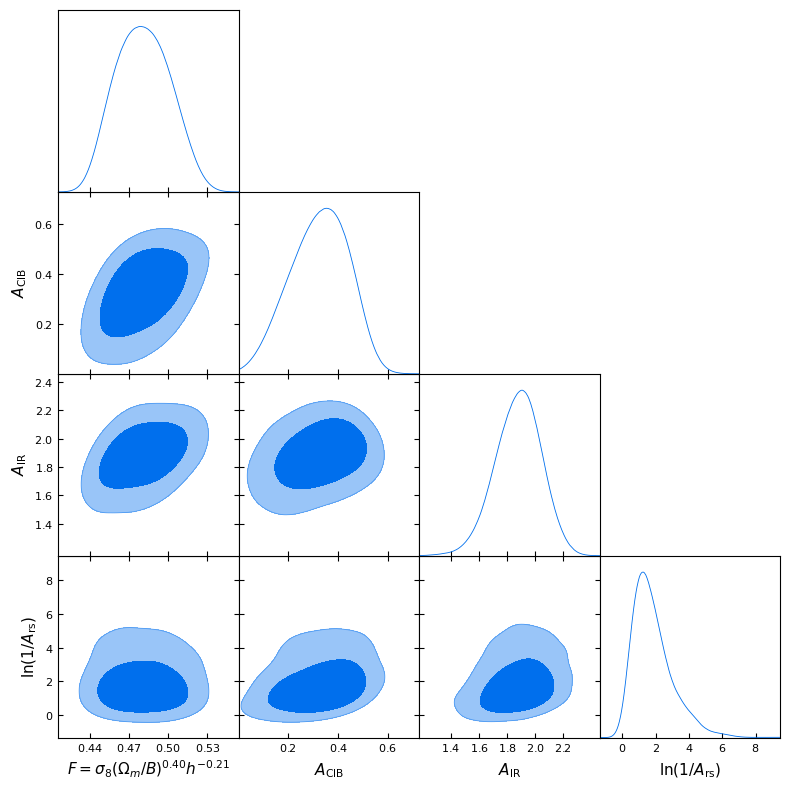

In [9]:
# Define parameters to plot
params_to_plot = ['F', 'A_cib', 'A_ir','ln_1_A_rs']

# Create a triangle plot (corner plot)
g = plots.get_subplot_plotter()
g.triangle_plot(readsamps, params_to_plot, filled=True)

# Adjust axis limits for specific parameters
# g.subplots[0, 0].set_xlim(0.42, 0.5)  # Adjust x-axis limit for 'F'
# g.subplots[1, 1].set_xlim(0, 1)  # Adjust x-axis limit for 'A_cib'
# g.subplots[2, 2].set_xlim(1.5, 2.5)  # Adjust x-axis limit for 'A_ir'
# g.subplots[3, 3].set_xlim(-1.5, 6) # Adjust x-axis limit for 'ln_1_A_rs'

# Show the plot
plt.show()